In [1]:
# 프로젝트 루트:
import sys, os
from pathlib import Path

# Jupyter에서 argparse 충돌 방지
sys.argv = ['']

# 프로젝트 루트(‘medication_object_detection_project_team2’)를 PATH에 추가
# → main.py, src/config.py 등 상대 경로 import를 위해
proj_root = Path().resolve().parent  # notebooks 폴더 안에서 실행 중이라면 parent가 Project 루트
sys.path.insert(0, str(proj_root))

print("▶ 프로젝트 루트:", proj_root)
print("▶ Python executable:", sys.executable)


▶ 프로젝트 루트: C:\Users\USER\Documents\GitHub\medication_object_detection_project_team2\Project
▶ Python executable: C:\Users\USER\AppData\Local\pypoetry\Cache\virtualenvs\meditation-detection-project-ihVzpsAT-py3.11\Scripts\python.exe


In [2]:
# config:
from src.config import get_config, get_device

cfg    = get_config()
device = get_device()

print(f"▶ Device          : {device}")
print(f"▶ Train 이미지 폴더: {cfg.train_image_dir}")
print(f"▶ Annotation 폴더 : {cfg.annotation_dir}")
print(f"▶ 출력(OUTPUT_DIR): {cfg.output_dir}")


▶ Device          : cuda
▶ Train 이미지 폴더: C:\Users\USER\Documents\GitHub\medication_object_detection_project_team2\data\ai03-level1-project\train_images
▶ Annotation 폴더 : C:\Users\USER\Documents\GitHub\medication_object_detection_project_team2\data\ai03-level1-project\train_annotations
▶ 출력(OUTPUT_DIR): C:\Users\USER\Documents\GitHub\medication_object_detection_project_team2\Project\outputs


In [3]:
# csv로 필터된 annotations와 id 매핑 로드
import pandas as pd
from src.utils.data_utils import load_filtered_df, load_mappings

# filtered_df.csv 에는 image_id, bbox_x,y,w,h, category_id 등이 들어있습니다.
filtered_df = load_filtered_df(cfg)
mappings    = load_mappings(cfg)

print(f"■ filtered_df shape : {filtered_df.shape}")
print(f"■ mappings keys     : {list(mappings.keys())}")


■ filtered_df shape : (2406, 8)
■ mappings keys     : ['category_id_map', 'image_id_map']


In [6]:
# 모듈 임포트 및 설정
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
from ultralytics import YOLO
from pathlib import Path

# 한글 + 마이너스 기호 폰트 설정 (경고 없이 한글/음수 렌더링)
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'Malgun Gothic']

# 클래스 이름 불러오기 (data.yaml 에서)
from pathlib import Path

yaml_path = Path(cfg.data_dir) / "data.yaml"
# 반드시 encoding='utf-8' 지정
with open(yaml_path, 'r', encoding='utf-8') as f:
    data_cfg = yaml.safe_load(f)

class_names = data_cfg['names']
print(class_names)


['보령부스파정 5mg', '뮤테란캡슐 100mg', '일양하이트린정 2mg', '기넥신에프정(은행엽엑스)(수출용)', '무코스타정(레바미피드)(비매품)', '알드린정', '뉴로메드정(옥시라세탐)', '타이레놀정500mg', '에어탈정(아세클로페낙)', '삼남건조수산화알루미늄겔정', '타이레놀이알서방정(아세트아미노펜)(수출용)', '삐콤씨에프정 618.6mg/병', '조인스정 200mg', '쎄로켈정 100mg', '리렉스펜정 300mg/PTP', '아빌리파이정 10mg', '자이프렉사정 2.5mg', '다보타민큐정 10mg/병', '써스펜8시간이알서방정 650mg', '에빅사정(메만틴염산염)(비매품)', '리피토정 20mg', '크레스토정 20mg', '가바토파정 100mg', '동아가바펜틴정 800mg', '오마코연질캡슐(오메가-3-산에틸에스테르90)', '란스톤엘에프디티정 30mg', '리리카캡슐 150mg', '종근당글리아티린연질캡슐(콜린알포세레이트)\xa0', '콜리네이트연질캡슐 400mg', '트루비타정 60mg/병', '스토가정 10mg', '노바스크정 5mg', '마도파정', '플라빅스정 75mg', '엑스포지정 5/160mg', '펠루비정(펠루비프로펜)', '아토르바정 10mg', '라비에트정 20mg', '리피로우정 20mg', '자누비아정 50mg', '맥시부펜이알정 300mg', '메가파워정 90mg/병', '쿠에타핀정 25mg', '비타비백정 100mg/병', '놀텍정 10mg', '자누메트정 50/850mg', '큐시드정 31.5mg/PTP', '아모잘탄정 5/100mg', '세비카정 10/40mg', '트윈스타정 40/5mg', '카나브정 60mg', '울트라셋이알서방정', '졸로푸트정 100mg', '트라젠타정(리나글립틴)', '비모보정 500/20mg', '레일라정', '리바로정 4mg', '렉사프로정 15mg', '트라젠타듀오정 2.5/850mg', '낙소졸정 500/20mg', '아질렉트정(라사길린메실산염)', '자누메트엑스알

In [7]:
# 학습된 모델 로드
model_path = f'{cfg.output_dir}/YOLO_20250722_104725/yolo_experiment/weights/best.pt'
model = YOLO(model_path)
model

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 32, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C3(
        (cv1): Conv(
          (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_st

In [8]:
# 코드 셀 4: 테스트 이미지 목록
test_dir = Path(f'{cfg.test_image_dir}')
images = list(test_dir.glob('*.png'))
print(f"Found {len(images)} test images. Showing first 5 examples.")
images[:5]


Found 843 test images. Showing first 5 examples.


[WindowsPath('C:/Users/USER/Documents/GitHub/medication_object_detection_project_team2/data/ai03-level1-project/test_images/1.png'),
 WindowsPath('C:/Users/USER/Documents/GitHub/medication_object_detection_project_team2/data/ai03-level1-project/test_images/10.png'),
 WindowsPath('C:/Users/USER/Documents/GitHub/medication_object_detection_project_team2/data/ai03-level1-project/test_images/100.png'),
 WindowsPath('C:/Users/USER/Documents/GitHub/medication_object_detection_project_team2/data/ai03-level1-project/test_images/1003.png'),
 WindowsPath('C:/Users/USER/Documents/GitHub/medication_object_detection_project_team2/data/ai03-level1-project/test_images/1004.png')]

In [11]:
# draw 함수
def draw_boxes_with_labels(
    image_path,
    boxes,        # numpy array, shape (N,4): [x1, y1, x2, y2]
    labels,       # list of str
    scores,       # list of float
    font_path="C:/Windows/Fonts/malgun.ttf",  # 환경에 맞춰 수정
    font_size=14,
    box_color=(255, 0, 0),
    text_color=(255, 255, 255),
    text_bg_color=(255, 0, 0),
    figsize=(8, 8)
):
    img = Image.open(image_path).convert("RGB")
    draw = ImageDraw.Draw(img)
    try:
        font = ImageFont.truetype(font_path, font_size)
    except IOError:
        font = ImageFont.load_default()

    for (x1, y1, x2, y2), label, score in zip(boxes, labels, scores):
        draw.rectangle([x1, y1, x2, y2], outline=box_color, width=2)
        text = f"{label} {score:.2f}"
        tw, th = draw.textsize(text, font=font)
        draw.rectangle([x1, y1-th, x1+tw, y1], fill=text_bg_color)
        draw.text((x1, y1-th), text, fill=text_color, font=font)

    plt.figure(figsize=figsize)
    plt.imshow(np.array(img))
    plt.axis("off")
    plt.show()




image 1/1 C:\Users\USER\Documents\GitHub\medication_object_detection_project_team2\data\ai03-level1-project\test_images\1.png: 640x512 (no detections), 38.7ms
Speed: 3.0ms preprocess, 38.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 512)


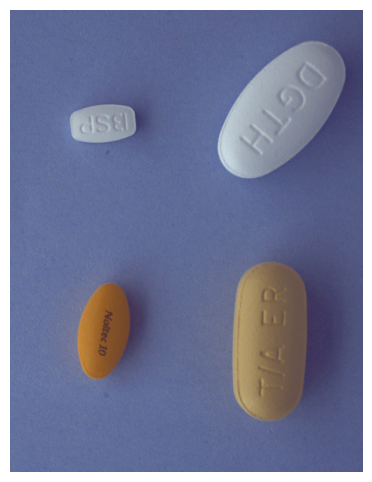


image 1/1 C:\Users\USER\Documents\GitHub\medication_object_detection_project_team2\data\ai03-level1-project\test_images\10.png: 640x512 (no detections), 38.3ms
Speed: 4.5ms preprocess, 38.3ms inference, 5.1ms postprocess per image at shape (1, 3, 640, 512)


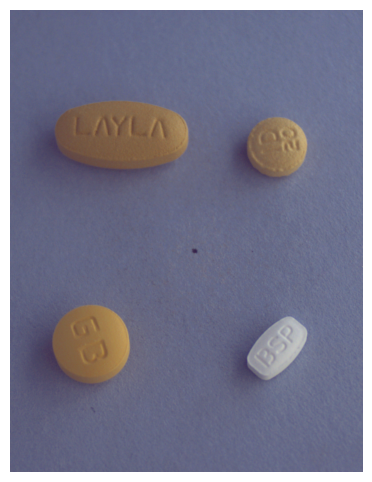


image 1/1 C:\Users\USER\Documents\GitHub\medication_object_detection_project_team2\data\ai03-level1-project\test_images\100.png: 640x512 (no detections), 38.2ms
Speed: 3.6ms preprocess, 38.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 512)


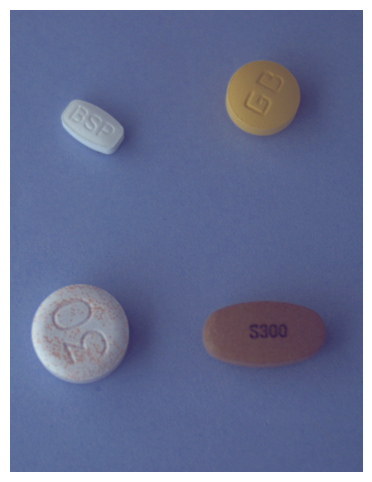


image 1/1 C:\Users\USER\Documents\GitHub\medication_object_detection_project_team2\data\ai03-level1-project\test_images\1003.png: 640x512 (no detections), 38.2ms
Speed: 4.2ms preprocess, 38.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 512)


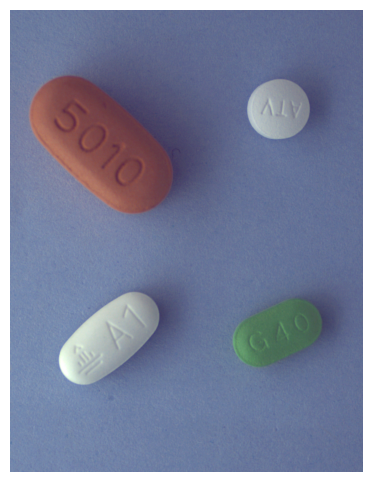


image 1/1 C:\Users\USER\Documents\GitHub\medication_object_detection_project_team2\data\ai03-level1-project\test_images\1004.png: 640x512 (no detections), 38.2ms
Speed: 3.0ms preprocess, 38.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 512)


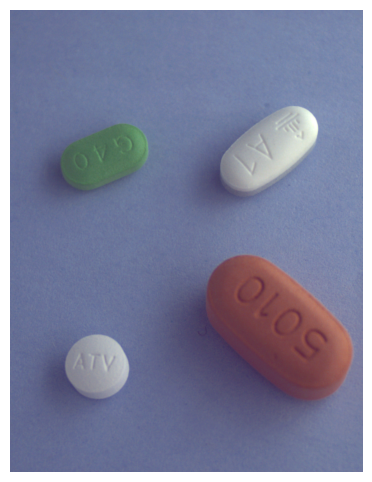


image 1/1 C:\Users\USER\Documents\GitHub\medication_object_detection_project_team2\data\ai03-level1-project\test_images\1005.png: 640x512 (no detections), 38.3ms
Speed: 4.1ms preprocess, 38.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 512)


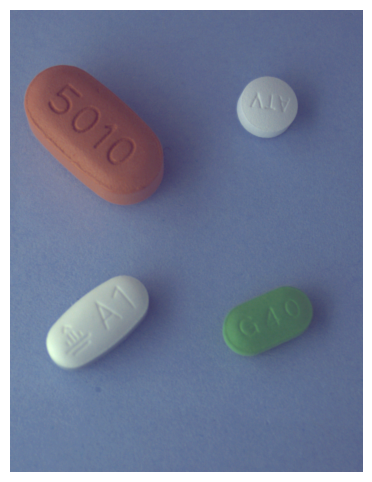


image 1/1 C:\Users\USER\Documents\GitHub\medication_object_detection_project_team2\data\ai03-level1-project\test_images\1006.png: 640x512 (no detections), 38.2ms
Speed: 3.4ms preprocess, 38.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 512)


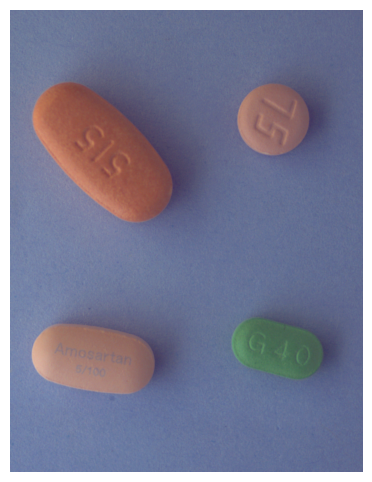


image 1/1 C:\Users\USER\Documents\GitHub\medication_object_detection_project_team2\data\ai03-level1-project\test_images\1007.png: 640x512 (no detections), 38.2ms
Speed: 3.5ms preprocess, 38.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


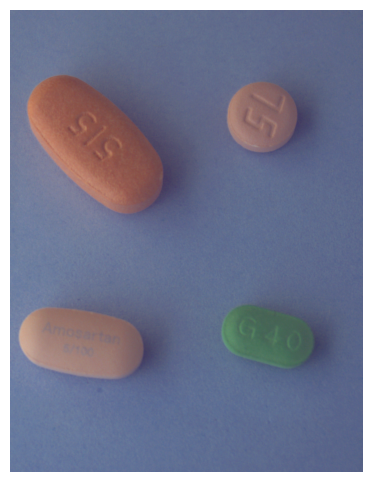


image 1/1 C:\Users\USER\Documents\GitHub\medication_object_detection_project_team2\data\ai03-level1-project\test_images\1009.png: 640x512 (no detections), 38.3ms
Speed: 3.9ms preprocess, 38.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 512)


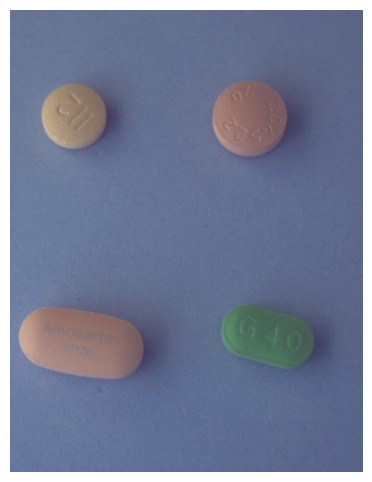


image 1/1 C:\Users\USER\Documents\GitHub\medication_object_detection_project_team2\data\ai03-level1-project\test_images\1010.png: 640x512 (no detections), 38.3ms
Speed: 4.2ms preprocess, 38.3ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 512)


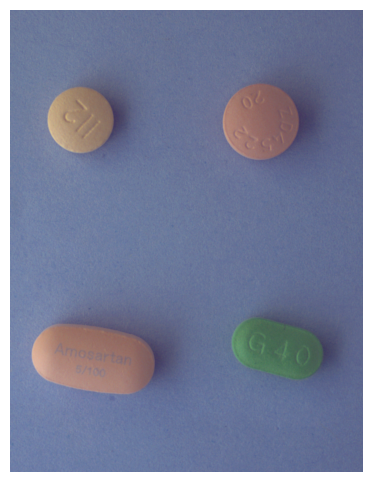

In [12]:

# 순회하며 예측 및 시각화
for img_path in images[:10]:  # 처음 10장만
    # a) 모델 추론
    res = model(str(img_path))[0]
    boxes_np = res.boxes.xyxy.cpu().numpy()      # (N,4)
    scores_np= res.boxes.conf.cpu().numpy()      # (N,)
    classes_np= res.boxes.cls.cpu().numpy().astype(int)  # (N,)

    # b) id → 이름 맵핑
    labels = [ class_names[c] for c in classes_np ]

    # c) 시각화
    draw_boxes_with_labels(
        image_path=img_path,
        boxes=boxes_np,
        labels=labels,
        scores=scores_np,
        font_path="C:/Windows/Fonts/malgun.ttf",  # 한글폰트 경로
        font_size=16,
        box_color=(0, 0, 255),
        text_bg_color=(0, 0, 255),
        text_color=(255, 255, 255),
        figsize=(6, 6)
    )
